In [12]:
import lightgbm as lgb
import pandas as pd 
import numba
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
from quadkey import * 
from sklearn import preprocessing, metrics
import shap

# Читаем данные

In [13]:
prices=pd.read_csv('P/price_train.tsv','	')
hb=pd.read_csv('P/price_housebase.tsv','	')


In [14]:
test=pd.read_csv('P/price_test.tsv','	')

In [15]:
prices.columns

Index(['apartment_ratio', 'offers_in_sites_ratio',
       'unique_active_buildings_count', 'avg_price_sqm', 'month',
       'unique_active_building_series_count', 'rooms_offered_3_ratio',
       'city_quadkey', 'median_price_sqm', 'rooms_offered_4_more_ratio',
       'rooms_offered_1_ratio', 'total_area_avg', 'studio_ratio',
       'offer_count', 'rooms_offered_2_ratio'],
      dtype='object')

In [16]:
hb.columns

Index(['beauty_cnt', 'building_id', 'building_series_id', 'shopping_cnt',
       'flats_count', 'latitude', 'building_type',
       'cafe_restaurant_eating_out_cnt', 'unified_address',
       'entertainment_cnt', 'sport_cnt', 'chain_cnt',
       'groceries_and_everyday_items_cnt', 'art_cnt', 'site_id',
       'healthcare_cnt', 'expect_demolition', 'longitude', 'ceiling_height',
       'has_elevator', 'laundry_and_repair_services_cnt', 'build_year',
       'city_quadkey'],
      dtype='object')

# Первичный анализ

### Разделяем ряды на группы по уровню средней стоимости квадратного метра

In [17]:
prices_trend=prices.groupby(by='city_quadkey',as_index=False)['avg_price_sqm'].mean()
prices_trend=prices_trend.sort_values(by='avg_price_sqm')

### Полученная кривая показывает что основная доля районов имеет среднюю стоимость кв метра меньше 200 000 р.

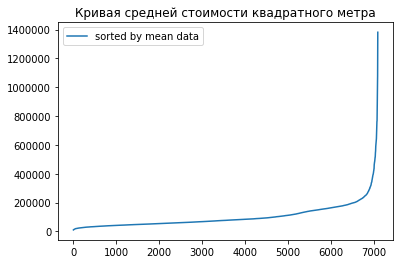

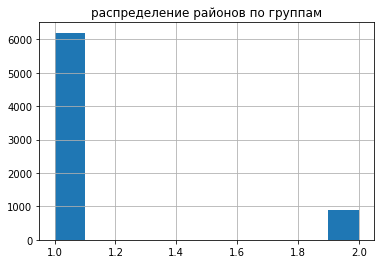

In [18]:
window=6200
part_counter=0
cntr=0
parts=[]
flag=0
while cntr<=int(len(prices_trend['city_quadkey'].drop_duplicates())/window):
    cntr+=1
    if(len(prices_trend['city_quadkey'][part_counter+window:part_counter+(window*2)])<window):
        pr=prices_trend[part_counter:part_counter+(window*2)]
        pr['qrt']=[cntr,]*len(pr)
    else:    
        pr=prices_trend[part_counter:part_counter+window]
        pr['qrt']=[cntr,]*len(pr)    
    parts.append(pr)
    part_counter+=window
prices_trend=pd.concat(parts)

prices=pd.merge(prices,prices_trend[['qrt','city_quadkey']],on='city_quadkey')
prices=prices.sort_values(by=['month','city_quadkey'],ascending =True)

plt.title('Кривая средней стоимости квадратного метра')
plt.plot(prices_trend['avg_price_sqm'].values,label='sorted by mean data')
plt.legend()
plt.show()

plt.title('распределение районов по группам')
prices_trend['qrt'].hist()
plt.show()

## Создаем признаки 

In [19]:
def create_fea(data):
    #vlst=data['avg_price_sqm']
   # data['avg_price_sqm']=np.log(vlst)
    data['lag_t1'] = np.log(data.groupby(['city_quadkey'])['avg_price_sqm'].transform(lambda x: x.shift(1)))
    data['lag_t2'] = np.log(data.groupby(['city_quadkey'])['avg_price_sqm'].transform(lambda x: x.shift(2)))
    data['lag_t3'] = np.log(data.groupby(['city_quadkey'])['avg_price_sqm'].transform(lambda x: x.shift(3)))
    data['lag_t4'] = np.log(data.groupby(['city_quadkey'])['avg_price_sqm'].transform(lambda x: x.shift(3)))
    data['lag_t5'] = np.log(data.groupby(['city_quadkey'])['avg_price_sqm'].transform(lambda x: x.shift(3)))
    data['lag_t6'] = np.log(data.groupby(['city_quadkey'])['avg_price_sqm'].transform(lambda x: x.shift(3)))
   # data['rolling_diff_t2'] = data.groupby(['city_quadkey'])['avg_price_sqm'].rolling(window=2).apply(lambda x: x.iloc[-1] - x.iloc[0]).values
    data['rolling_mean_t7'] = np.log(data.groupby(['city_quadkey'])['avg_price_sqm'].transform(lambda x: x.shift(1).rolling(7).mean()))
    data['rolling_std_t7'] = np.log(data.groupby(['city_quadkey'])['avg_price_sqm'].transform(lambda x: x.shift(1).rolling(7).std()))
    data['rolling_median_t7'] = np.log(data.groupby(['city_quadkey'])['avg_price_sqm'].transform(lambda x: x.shift(1).rolling(7).median()))
    data_colums=['city_quadkey','month','qrt','avg_price_sqm','lag_t1','lag_t2','lag_t3','lag_t4','lag_t5','lag_t6','rolling_mean_t7','rolling_std_t7','rolling_median_t7']
    return(data[data_colums])
vls=prices['avg_price_sqm']
data=create_fea(prices)


In [20]:
data

,city_quadkey,month,qrt,avg_price_sqm,lag_t1,lag_t2,lag_t3,lag_t4,lag_t5,lag_t6,rolling_mean_t7,rolling_std_t7,rolling_median_t7
4,120132231322113,2017-01-01,1,36250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,120132231331111,2017-01-01,1,44800.605469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,120132231331113,2017-01-01,1,42130.444336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126,120132232101331,2017-01-01,1,29038.113281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,120132232121033,2017-01-01,1,51955.955729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165911,120311020001133,2019-08-01,1,19444.445312,9.875317,9.875317,9.875317,9.875317,9.875317,9.875317,9.927502,7.169493,9.875317
165943,120311020001311,2019-08-01,1,21636.634476,9.972754,9.982689,9.978741,9.978741,9.978741,9.978741,9.966671,5.884700,9.972754
165969,120311020010022,2019-08-01,1,25000.000000,10.126631,10.126631,10.126631,10.126631,10.126631,10.126631,10.126631,-inf,10.126631
165994,120311020010200,2019-08-01,1,21518.150635,9.976652,9.976652,9.976652,9.976652,9.976652,9.976652,9.962387,5.953468,9.976652


In [21]:
#data['diff']=data['lag_t1']-data['lag_t2']
data_columns=['city_quadkey','lag_t1','lag_t2','lag_t3','lag_t4','lag_t5','lag_t6','rolling_mean_t7','rolling_std_t7','rolling_median_t7']

# Обучение

In [22]:
print('max date',prices['month'].max())
print('min date',prices['month'].min())

max date 2019-08-01
min date 2017-01-01


In [23]:
train=data[data['month']<='2019-06-01']
val=data[data['month']>'2019-06-01']

In [24]:
val['qrt'].value_counts()

1    8797
2    1674
Name: qrt, dtype: int64

learning rate:  0.01
power:  50000
objective:  tweedie
boosting_type:  gbdt
Fit model...
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 16824.3	valid_1's rmse: 19303.5
[200]	training's rmse: 8734.81	valid_1's rmse: 8935.77
[300]	training's rmse: 6607.23	valid_1's rmse: 5623.5
[400]	training's rmse: 6165.24	valid_1's rmse: 4839.86
[500]	training's rmse: 6039.08	valid_1's rmse: 4672.05
[600]	training's rmse: 5982.5	valid_1's rmse: 4628.71
[700]	training's rmse: 5934.05	valid_1's rmse: 4606.65
[800]	training's rmse: 5908.92	valid_1's rmse: 4594.49
[900]	training's rmse: 5889.28	valid_1's rmse: 4582.01
[1000]	training's rmse: 5867.74	valid_1's rmse: 4574.13
[1100]	training's rmse: 5849.56	valid_1's rmse: 4569.33
[1200]	training's rmse: 5834.05	valid_1's rmse: 4567.09
[1300]	training's rmse: 5816.33	valid_1's rmse: 4565.69
[1400]	training's rmse: 5800.2	valid_1's rmse: 4564.65
[1500]	training's rmse: 5784.3	valid_1's rmse: 4562.5
[1600]	training's rmse:

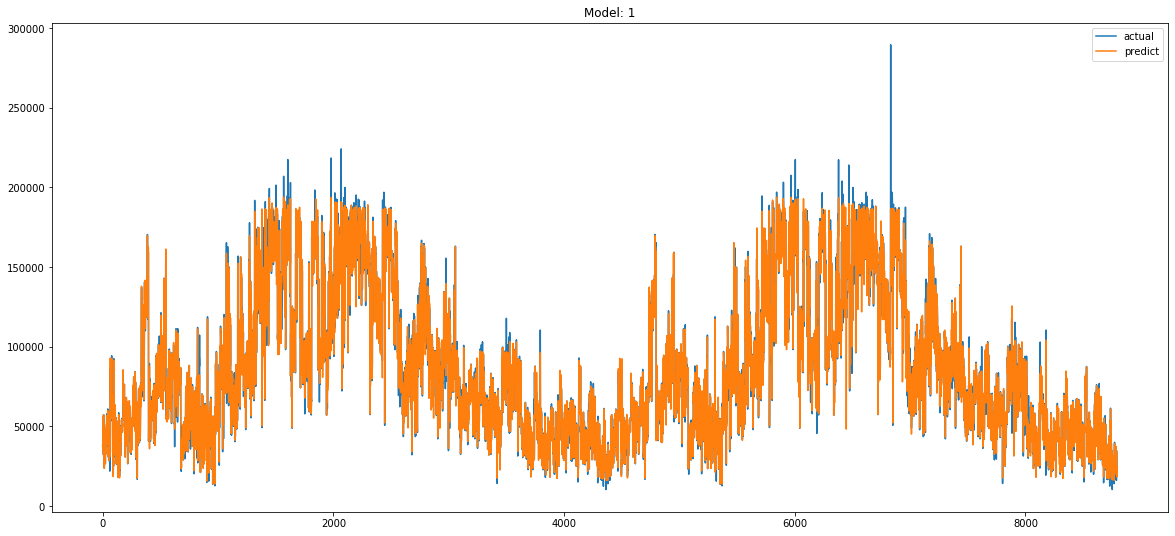

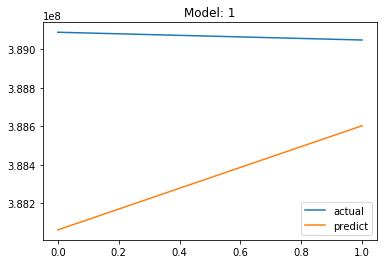

learning rate:  0.03
power:  50000
objective:  tweedie
boosting_type:  gbdt
Fit model...
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 30415.4	valid_1's rmse: 18403.2
[200]	training's rmse: 26619.3	valid_1's rmse: 13631
Early stopping, best iteration is:
[178]	training's rmse: 26875.6	valid_1's rmse: 13531.6
Our val rmse score is 13531.588853641824


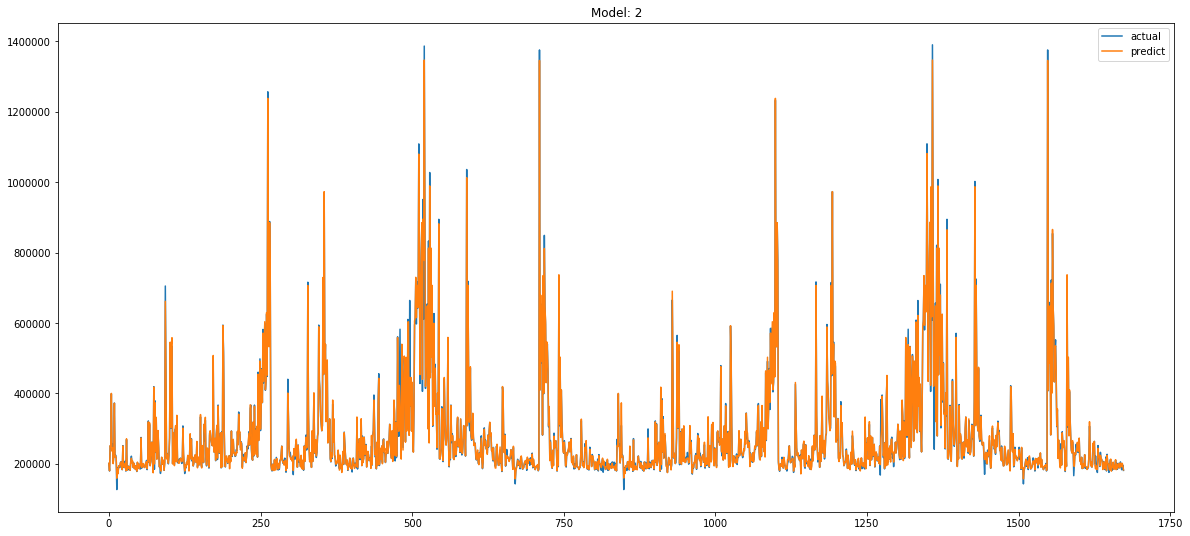

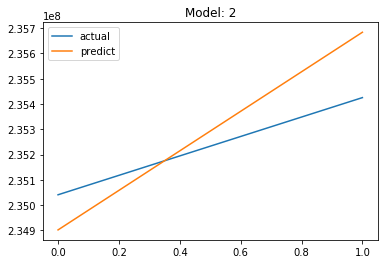

In [27]:

trees=[50000,]*len(data['qrt'].drop_duplicates())
objects=['tweedie','tweedie']#*len(data['qrt'].drop_duplicates())
types=['gbdt',]*len(data['qrt'].drop_duplicates())
mtrics=['rmse','rmse']
steps=[0.01,0.03]
gbm_box=[]

for i in range(1,train['qrt'].max()+1):
    train_x= train[(train['qrt']==i)][data_columns].fillna(0)
    train_y= train[(train['qrt']==i)]['avg_price_sqm']
    val_x  = val[(val['qrt']==i)][data_columns].fillna(0)
    xal_y  = val[(val['qrt']==i)]['avg_price_sqm']


    gbm=FitGBM(train_x,train_y,val_x,xal_y,trees[i-1],objects[i-1],types[i-1],steps[i-1],mtrics[i-1])

    #explainer = shap.TreeExplainer(gbm)
    #shap_values = explainer.shap_values(val_x[data_columns])
    #shap.summary_plot(shap_values,val_x[data_columns])
    #plt.show()

    gbm_box.append(gbm)
    plt.figure(figsize=(20,9))
    plt.plot(val[val['qrt']==i]['avg_price_sqm'].values,label='actual')
    plt.plot(gbm.predict(val[val['qrt']==i][data_columns]),label='predict')
    plt.title('Model: '+str(i))
    plt.legend()
    plt.show()

    plt.title('Model: '+str(i))
    val_plt=val[val['qrt']==i]
    val_plt['actual']=xal_y
    val_plt['predict']=gbm.predict(val[val['qrt']==i][data_columns])
    val_plt=val_plt.groupby(by=['month'],as_index=False).agg({'actual':'sum','predict':'sum'})
    plt.plot(val_plt['actual'],label='actual')
    plt.plot(val_plt['predict'],label='predict')
    plt.legend()
    plt.show()

# Predict

In [28]:
qks=test['city_quadkey'].drop_duplicates()
data_test=data[data['city_quadkey'].isin(qks)==True]

In [29]:
import calendar
def increment_month(date):
    # Go to first of this month, and add 32 days to get to the next month
    next_month = date.replace(day=1) + datetime.timedelta(32)
    # Get the day of month that corresponds
    day = min(date.day, calendar.monthrange(next_month.year, next_month.month)[1])
    return next_month.replace(day=day)

In [32]:
import  datetime
from tqdm import tqdm
def predict(test_df,gbm_box,dict_qc,codid):
    skip=0
    if(dict_qc.get(codid)):
        test_df=test_df[test_df['city_quadkey']==codid]
    else:
        #temp_ck=int(find_closer(codid,qk_ll)[0])
        #test_df=test_df[test_df['city_quadkey']==temp_ck]
        skip=1
        
    wind=7
    qrt=test_df['qrt'].max()
    gbm=gbm_box[qrt-1]
    cqk=test_df['city_quadkey'].max()
    #unique_active_buildings_count=test_df['unique_active_buildings_count'].max()
    horizone_date='2020-03-01'
    data=test_df[-wind:]
    temp_date=data['month'].max()
    temp_date = datetime.datetime.strptime(temp_date, '%Y-%m-%d')
    temp_date2=pd.to_datetime(horizone_date, format='%Y-%m-%d')
    target=data['avg_price_sqm'].values.tolist()
    dates=[]
    result=[]
    new_target=[]
    if(len(target)<wind):
        point=target[-len(target)]
        for i in range(wind-len(target)):
            new_target.append(point)
        for i in target:
            new_target.append(i)
        target=new_target   
   
    while True:
        temp_date=increment_month(temp_date)
        if(temp_date>temp_date2):
            break   
        dates.append(temp_date)
        lag_t1=np.log(target[-1])
        lag_t2=np.log(target[-2])
        diff=lag_t1-lag_t2
        lag_t3=np.log(target[-3])
        lag_t4=np.log(target[-4])
        lag_t5=np.log(target[-5])
        lag_t6=np.log(target[-6])
        rolling_mean_t7   = np.log(np.mean(target[-7:]))
        rolling_std_t7   = np.log(np.std(target[-7:]))
        rolling_median_t7   = np.log(np.median(target[-7:]))
        temp_pred=[cqk,lag_t1,lag_t2,lag_t3,lag_t4,lag_t5,lag_t6,rolling_mean_t7,rolling_std_t7,rolling_median_t7]
        #xgb_pred=pd.DataFrame([temp_pred])
        #xgb_pred.columns= ['city_quadkey', 'lag_t1', 'lag_t2', 'lag_t3', 'lag_t4', 'lag_t5', 'lag_t6', 'rolling_mean_t7', 'rolling_std_t7', 'rolling_median_t7']
        pred=gbm.predict(np.array(temp_pred).reshape((1,-1)))
        #pred=gbm.predict(xgb_pred)
        target.append(pred[0])
        if(skip==1):
            result.append(0)
        else:
            result.append(pred[0])

    cqks=[codid,]*(len(result))
    res=pd.DataFrame()
    res['avg_price_sqm']=result
    res['month']=dates
    res['city_quadkey']=cqks
    return(res)

results=[]
for elem in tqdm(test['city_quadkey'].drop_duplicates()):
    results.append(predict(data_test,gbm_box,dict_cq,elem))
    #results.append(predict(data_test,gbmx_box,dict_cq,elem))
results=pd.concat(results)

100%|██████████| 6121/6121 [01:30<00:00, 68.01it/s]


In [33]:
results=results[results['month']>='2019-09-01']

In [34]:
results

,avg_price_sqm,month,city_quadkey
0,0.000000,2019-09-01,120132230323210
1,0.000000,2019-10-01,120132230323210
2,0.000000,2019-11-01,120132230323210
3,0.000000,2019-12-01,120132230323210
4,0.000000,2020-01-01,120132230323210
...,...,...,...
2,18848.910127,2019-11-01,120311020100310
3,18848.910127,2019-12-01,120311020100310
4,18848.910127,2020-01-01,120311020100310
5,18848.910127,2020-02-01,120311020100310


In [49]:
table_zeros_box=[]
for elem in tqdm(results[results['avg_price_sqm']==0]['city_quadkey'].drop_duplicates()):
    cq=find_closer(elem,qk_ll).sort_values(by='dist').head(3)
    table_zeros=results[results['city_quadkey'].isin(cq['keys'].values)==True]
    table_zeros=table_zeros.groupby(by='month',as_index=False)['avg_price_sqm'].mean()
    names=[elem,]*len(table_zeros['avg_price_sqm'])
    table_zeros['city_quadkey']=names
    table_zeros_box.append(table_zeros)
table_zeros_box.append(results[results['avg_price_sqm']!=0])
table_zeros_box=pd.concat(table_zeros_box)
test=pd.read_csv('P/price_test.tsv','	')
test['month']=test['month'].astype('datetime64[ns]')
test=pd.merge(test,table_zeros_box,on=['month','city_quadkey'],how='left')
test

100%|██████████| 300/300 [03:32<00:00,  1.41it/s]


,month,city_quadkey,avg_price_sqm
0,2020-03-01,120132230323210,43045.376602
1,2019-09-01,120132231322113,37998.953218
2,2019-10-01,120132231322113,37998.953218
3,2019-11-01,120132231322113,37998.953218
4,2019-12-01,120132231322113,37998.953218
...,...,...,...
38025,2019-11-01,120311020100310,18848.910127
38026,2019-12-01,120311020100310,18848.910127
38027,2020-01-01,120311020100310,18848.910127
38028,2020-02-01,120311020100310,18848.910127


In [784]:
tbl=results['city_quadkey'].value_counts()

In [48]:
#test=pd.read_csv('P/price_test.tsv','	')
#test['month']=test['month'].astype('datetime64[ns]')
##test=pd.merge(test,results,on=['month','city_quadkey'],how='left')
#test['avg_price_sqm']=test['avg_price_sqm'].fillna(mv)
#test

,month,city_quadkey,avg_price_sqm
0,2020-03-01,120132230323210,0.000000
1,2019-09-01,120132231322113,37998.953218
2,2019-10-01,120132231322113,37998.953218
3,2019-11-01,120132231322113,37998.953218
4,2019-12-01,120132231322113,37998.953218
...,...,...,...
38025,2019-11-01,120311020100310,18848.910127
38026,2019-12-01,120311020100310,18848.910127
38027,2020-01-01,120311020100310,18848.910127
38028,2020-02-01,120311020100310,18848.910127


In [46]:
mv=test['avg_price_sqm'].median()/2
mv

44673.7310036189

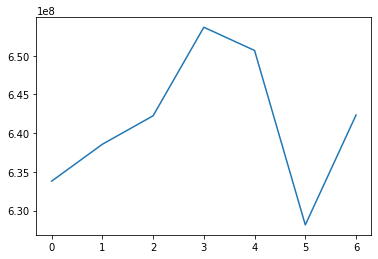

In [50]:
results_plt=test.groupby(by='month',as_index=False)['avg_price_sqm'].sum()
plt.plot(results_plt['avg_price_sqm'].values)

In [51]:

test[['city_quadkey','month','avg_price_sqm']].to_csv('sample_submission.tsv','	',index=False)

## LGBM

In [26]:

def FitGBM(X_train,Y_train, X_val=0, Y_val=0,power=1500,objective='tweedie',types='gbdt',step=0.01,metric='rmse'):
    
    print('learning rate: ',step)
    print('power: ',power)
    print('objective: ',objective)
    print('boosting_type: ',types)
    params = {
        #'extra_trees ':'true',
        'boosting_type': types,
        'metric': metric,
        'objective': objective,
        'n_jobs': -1,
        'learning_rate':step,
        #'max_bin':15,
        #'num_iterations':50000, 
       # 'bagging_fraction': 0.75,
       # 'bagging_freq': 10, 
       # 'colsample_bytree': 0.75,
        'n_estimators':power,
        #,
       # 'num_leaves':2**6,
       # 'max_depth':8
        }
   
    print('Fit model...')
    train_set = lgb.Dataset(X_train, Y_train)
    val_set = lgb.Dataset(X_val, Y_val)
    gbm = lgb.train(params,train_set, num_boost_round = 2500, early_stopping_rounds = 100, valid_sets = [train_set, val_set], verbose_eval = 100)
    val_pred = gbm.predict(X_val)
    val_score = np.sqrt(metrics.mean_squared_error(val_pred, Y_val))
    print(f'Our val rmse score is {val_score}')
    return(gbm)

## XGB

In [602]:
from xgboost import XGBRegressor
    
def fit_xgb(X_train,Y_train,X_val,Y_val):
    eval_set = [(X_val, Y_val)]
    model = XGBRegressor()
    model.fit(X_train, Y_train, early_stopping_rounds=100,eval_metric="rmse", eval_set=eval_set, verbose=True);
    pred=model.predict(X_val)
    val_score = np.sqrt(metrics.mean_squared_error(pred, Y_val))
    print(f'Our val rmse score is {val_score}')
    return(gbm)
fit_xgb(train_x,train_y,val_x,xal_y)

# Поиск ближайших районов по координатам

In [30]:
quadkeys=[]
lats=[]
lons=[]
for elem in data_test['city_quadkey'].drop_duplicates():
    quadkeys.append(elem)
    lat,lon=quadkey2latlon(str(elem))
    lats.append(lat)
    lons.append(lon)
qk_ll=pd.DataFrame()
qk_ll['city_quadkey']=quadkeys
qk_ll['lat']=lats
qk_ll['lon']=lons
qk_ll=qk_ll.sort_values(by='city_quadkey')
qk_ll['flag']=1
qk_ll.index=qk_ll['city_quadkey']
dict_cq=qk_ll[['flag']].to_dict('index')

In [31]:
def find_closer(quadkey,qk_ll):
    lat,lon=quadkey2latlon(str(quadkey))
    min_dist=[]
    cq=[]
    for index,row in qk_ll.iterrows():
        dist=np.sqrt((lat - row['lat'])**2+(lon - row['lon'])**2)
        #if(dist<min_dist):
        #min_dist=dist
        min_dist.append(dist)
        cq.append(row['city_quadkey'])
    rate=pd.DataFrame()
    rate['dist']=min_dist
    rate['keys']=cq   
    return(rate)
code_test=120132232030210
cq=find_closer(code_test,qk_ll).sort_values(by='dist').head(5)
table_zeros=results[results['city_quadkey'].isin(cq['keys'].values)==True]
table_zeros=table_zeros.groupby(by='month',as_index=False)['avg_price_sqm'].mean()
table_zeros

NameError: name 'results' is not defined

# Добавляем признаки

Index(['beauty_cnt', 'building_id', 'building_series_id', 'shopping_cnt',
       'flats_count', 'latitude', 'building_type',
       'cafe_restaurant_eating_out_cnt', 'unified_address',
       'entertainment_cnt', 'sport_cnt', 'chain_cnt',
       'groceries_and_everyday_items_cnt', 'art_cnt', 'site_id',
       'healthcare_cnt', 'expect_demolition', 'longitude', 'ceiling_height',
       'has_elevator', 'laundry_and_repair_services_cnt', 'build_year',
       'city_quadkey'],
      dtype='object')

Index(['apartment_ratio', 'offers_in_sites_ratio',
       'unique_active_buildings_count', 'avg_price_sqm', 'month',
       'unique_active_building_series_count', 'rooms_offered_3_ratio',
       'city_quadkey', 'median_price_sqm', 'rooms_offered_4_more_ratio',
       'rooms_offered_1_ratio', 'total_area_avg', 'studio_ratio',
       'offer_count', 'rooms_offered_2_ratio', 'qrt', 'lag_t1', 'lag_t2',
       'lag_t3', 'lag_t4', 'lag_t5', 'lag_t6', 'rolling_diff_t2',
       'rolling_mean_t7', 'rolling_std_t7', 'rolling_median_t7'],
      dtype='object')

In [640]:
pr_fe=prices.groupby(by='city_quadkey',as_index=False)['unique_active_buildings_count']
data=pd.merge(data,pr_fe,how='left',on='city_quadkey')
data.head()

,city_quadkey,month,qrt,avg_price_sqm,lag_t1,lag_t2,lag_t3,lag_t4,lag_t5,lag_t6,rolling_diff_t2,rolling_mean_t7,rolling_std_t7,rolling_median_t7,build_year,unique_active_buildings_count
0,120132231322113,2017-01-01,1,36250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1979.0,4.0
1,120132231331111,2017-01-01,1,44800.605469,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1963.0,4.5
2,120132231331113,2017-01-01,1,42130.444336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1960.0,7.0
3,120132232101331,2017-01-01,1,29038.113281,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,2013.0,1.0
4,120132232121033,2017-01-01,1,51955.955729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1960.0,2.0


In [649]:
data['mn']=data['month'].astype('datetime64[ns]').month(

In [650]:
data

,city_quadkey,month,qrt,avg_price_sqm,lag_t1,lag_t2,lag_t3,lag_t4,lag_t5,lag_t6,rolling_diff_t2,rolling_mean_t7,rolling_std_t7,rolling_median_t7,build_year,unique_active_buildings_count,mn
0,120132231322113,2017-01-01,1,36250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1979.0,4.0,1
1,120132231331111,2017-01-01,1,44800.605469,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,1963.0,4.5,1
2,120132231331113,2017-01-01,1,42130.444336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1960.0,7.0,1
3,120132232101331,2017-01-01,1,29038.113281,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,2013.0,1.0,1
4,120132232121033,2017-01-01,1,51955.955729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1960.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166022,120311020001133,2019-08-01,1,19444.445312,19444.445312,19444.445312,19444.445312,19444.445312,19444.445312,19444.445312,-60.286418,20486.111607,1299.186129,19444.445312,1960.0,1.0,8
166023,120311020001311,2019-08-01,1,21636.634476,21434.437647,21648.453163,21563.148890,21563.148890,21563.148890,21563.148890,310.863629,21304.445271,359.494784,21434.437647,1955.0,12.0,8
166024,120311020010022,2019-08-01,1,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25.681885,25000.000000,0.000000,25000.000000,1960.0,1.0,8
166025,120311020010200,2019-08-01,1,21518.150635,21518.150635,21518.150635,21518.150635,21518.150635,21518.150635,21518.150635,-33.770136,21213.380894,385.086512,21518.150635,1960.0,6.0,8


In [202]:
prices[['city_quadkey','unique_active_buildings_count']]

,city_quadkey,unique_active_buildings_count
4,120132231322113,1
36,120132231331111,3
68,120132231331113,4
126,120132232101331,1
145,120132232121033,2
...,...,...
165911,120311020001133,1
165943,120311020001311,20
165969,120311020010022,1
165994,120311020010200,7


In [197]:
prices

,apartment_ratio,offers_in_sites_ratio,unique_active_buildings_count,avg_price_sqm,month,unique_active_building_series_count,rooms_offered_3_ratio,city_quadkey,median_price_sqm,rooms_offered_4_more_ratio,...,studio_ratio,offer_count,rooms_offered_2_ratio,qrt,lag_t1,lag_t2,lag_t3,rolling_mean_t7,rolling_std_t7,rolling_median_t7
4,0.0,0.0,1,36250.000000,2017-01-01,1,1.000000,120132231322113,35714.285156,0.0,...,0.0,3,0.000000,1,NaN,NaN,NaN,NaN,NaN,NaN
36,0.0,0.0,3,44800.605469,2017-01-01,1,0.000000,120132231331111,45383.523438,0.0,...,0.0,4,0.500000,1,NaN,NaN,NaN,NaN,NaN,NaN
68,0.0,0.0,4,42130.444336,2017-01-01,1,0.000000,120132231331113,40370.371094,0.0,...,0.0,4,0.250000,1,NaN,NaN,NaN,NaN,NaN,NaN
126,0.0,0.0,1,29038.113281,2017-01-01,1,1.000000,120132232101331,29038.113281,0.0,...,0.0,1,0.000000,1,NaN,NaN,NaN,NaN,NaN,NaN
145,0.0,0.0,2,51955.955729,2017-01-01,2,0.666667,120132232121033,50096.335938,0.0,...,0.0,3,0.333333,1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165911,0.0,0.0,1,19444.445312,2019-08-01,1,0.000000,120311020001133,19444.445312,0.0,...,0.0,1,0.000000,1,19444.445312,19444.445312,19444.445312,20486.111607,1299.186129,19444.445312
165943,0.0,0.0,20,21636.634476,2019-08-01,1,0.092593,120311020001311,21296.296875,0.0,...,0.0,54,0.740741,1,21434.437647,21648.453163,21563.148890,21304.445271,359.494784,21434.437647
165969,0.0,0.0,1,25000.000000,2019-08-01,1,0.000000,120311020010022,25000.000000,0.0,...,0.0,1,0.000000,1,25000.000000,25000.000000,25000.000000,25000.000000,0.000000,25000.000000
165994,0.0,0.0,7,21518.150635,2019-08-01,1,0.166667,120311020010200,20000.000000,0.0,...,0.0,12,0.750000,1,21518.150635,21518.150635,21518.150635,21213.380894,385.086512,21518.150635
